# Introduction
This is a preliminary topic modeling for the network data with behavior. For now we only focus on the individual behaviors. Individuals can tag products into their profiles. These products usually contain either a title or a description.

We need to keep only the relevant individuals. That means indiduals who appear in our network.  Ideally product titles should be enough to determine the product basket of individuals. In some cases although the title is not given and hence we might have access to the description or vice versa. This way we can increment our tokens by filling the empty fields accordingly. For a better understanding we can see how sparse the information in the titles are. If needed we can sublement the text with the description too.

Furthermore, we believe products with often tagging behavior from individuals are more informative about the nature of the topics. Hence, we discard the products that are only adopted for small number of times.

In our context, individuals are the documents, a collection of words associated with the products they have adopted. Our goal is to uncover the common topics among these documents. Henceforth, individuals with little activity are commonly discarded as the document associated with them consists of only few words.



In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import string
import nltk

nltk.download('wordnet')
nltk.download('stopwords')


[nltk_data] Downloading package wordnet to
[nltk_data]     /home/arashyazdiha/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/arashyazdiha/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Reading in the relevant data
In this section we read in the product, individual product behavior, and network data.

In [3]:
dir_path = '../dcdir/data/NetworkData/'
pp_dir = './pp.csv'
product_ids_dir = './product_ids.csv'
product_dir = os.path.join(dir_path, "products.csv")

product_ids = pd.read_csv(product_ids_dir, header=None, low_memory=False, dtype=str).loc[:, 0]
# print(product_ids[:3])
person_products = pd.read_csv(pp_dir, index_col=False, low_memory=False, dtype={'productId':str})
# print(person_products.head(3))
products_raw = pd.read_csv(product_dir, index_col=False, low_memory=False, dtype={'id':str})
products = products_raw.drop(columns=['discoveredSince', 'hivesNumber', 'lastRefreshDate', 'originator', 'profile', 'url'])



Next we try to keep only relevant observations. We do not want those with too dew actions or products with too few copies. So we plot how the counts look like.

  productId         personId
0       330  melodyjoyangel7
1       330       ARTandSOUL
2       330           olgirl
3       330         stylebee
4       330     aloudallowed
5       330      nondescript
6       330   HippiePrincess
7       330     BaltimoreGal
8       330              Bex
9       330        julie3jax


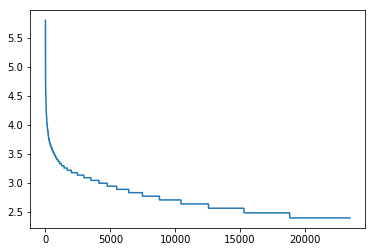

In [4]:
# products_raw.dtypes
print(person_products.head(10))
product_counts = person_products.productId.value_counts()

plt.plot(range(len(product_counts)), np.log(product_counts))
# print(max(product_counts[16000:20000]))
# print(min(product_counts))
# print(max(action_counts[17000:20000]))


In [80]:
person_products.shape

(382043, 2)

To filter out the relevant ones, we do the following:

minimum of product counts is 6
minimum of individual action counts is 5


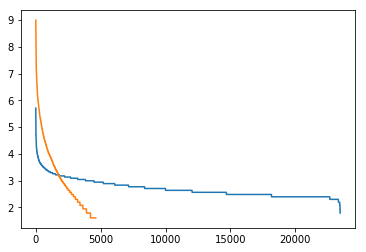

In [5]:
action_counts = person_products.personId.value_counts()

pp = person_products[person_products.groupby("personId")["personId"].transform('size') > 4]
pp = pp[pp.groupby("productId")["productId"].transform('size') > 4]

product_counts = pp.productId.value_counts()
plt.plot(range(len(product_counts)), np.log(product_counts))
print("minimum of product counts is {}".format(min(product_counts)))

action_counts = pp.personId.value_counts()
plt.plot(range(len(action_counts)), np.log(action_counts))
min(action_counts)
print("minimum of individual action counts is {}".format(min(action_counts)))

We can trim the products dataframe more by only keeping the relevant products.

In [6]:
unique_products = pp.productId.unique()
products = products.loc[products['id'].isin(unique_products)]
products.shape


(23451, 3)

# Constructing the text data
In this section we take a look at the available text data. This includes texts from the titles of the products and their description. To see how we should use such information. We first take a look at their availability for the products under investigation. We expect to have empty values for either of title or description data.

In [7]:
#first fill null values to ""
products.title.fillna("", inplace=True)
products.description.fillna("", inplace=True)
def empty_text(text):
    return (len(text.split()) == 0)
    

print("there are {} empty texts in title".format(products.title.apply(empty_text).sum()))
print("there are {} empty texts in description".format(products.description.apply(empty_text).sum()))

there are 0 empty texts in title
there are 7156 empty texts in description


The above shows that there are quite some products around ~30% of the descriptions are empty.
So we replace the descriptions in those cases with the title

In [8]:
products.loc[products.description == "", ["description"]] = products.title
print("there are {} empty texts in description".format(products.description.apply(empty_text).sum()))

there are 0 empty texts in description


Another option is to conjoin the texts from both fields(maybe later)

In [9]:
products['text'] = products.description + ' ' + products.title
products = products.rename(columns = {'title':'ttext', 'description':'dtext'})
products.columns.values


array(['id', 'dtext', 'ttext', 'text'], dtype=object)

# Text Cleaning

Text preparation includes filtering eligible charactgers, converting to lower case, removing duplicates, and stopwords, lemmatizing and stemming. For now we only take a look into the title text of the products.


In [10]:
from nltk.tokenize import RegexpTokenizer
from stop_words import get_stop_words
# from nltk.stem.porter import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer


tokenizer = RegexpTokenizer(r'\w+')
en_stop = get_stop_words('en')
# stemmer = PorterStemmer()
lemmer = WordNetLemmatizer()

# print(tokenizer.tokenize(temp_text.lower()))
# print([i for i in tokenizer.tokenize(temp_text.lower()) if not i in en_stop])


In [11]:
products.ttext = products.ttext.apply(lambda x: x.lower())
products.ttext = products.ttext.apply(lambda x: tokenizer.tokenize(x))

In [12]:
def preprocess(text):
    token_list = [token for token in text if token not in en_stop]
    token_list = [token for token in token_list if len(token) > 2]
    token_list = [token for token in token_list if not token.isnumeric()]
    token_list = [lemmer.lemmatize(token) for token in token_list]
    return token_list

Check few rows:

In [13]:
products['ttext'] = products.ttext.apply(preprocess)
print(products.ttext[:10])

4             [mary, angus, art, glass, perfume, bottle]
11                     [neo, geo, sphere, glass, vessel]
13                     [bobtanicals, duo, glass, vessel]
15                            [dotty, pillow, set, wool]
59                 [brad, reed, nelson, asian, inspired]
180                           [nfridge, modular, fridge]
479     [twilight, three, light, chandelier, chandelier]
734                       [etsy, blue, kokeshi, earring]
791    [juicy, couture, belted, velvet, jacket, nords...
881                                    [workplace, dish]
Name: ttext, dtype: object


Now The documents are the collection of the ones an individual has adopted. This means for each individual we need all their actions, and then combining all the keywords from those actions.

In [15]:
from gensim.models import Phrases


bigram = Phrases(products.ttext, min_count=20)
for i in range(products.shape[0]):
    rowIndex = products.index[i]
    for token in bigram[products.loc[rowIndex,'ttext']]:
        if '_' in token:
            products.loc[rowIndex,'ttext'].append(token)

print(products.ttext.head(10))


4      [mary, angus, art, glass, perfume, bottle, art...
11                     [neo, geo, sphere, glass, vessel]
13                     [bobtanicals, duo, glass, vessel]
15                            [dotty, pillow, set, wool]
59                 [brad, reed, nelson, asian, inspired]
180                           [nfridge, modular, fridge]
479     [twilight, three, light, chandelier, chandelier]
734                       [etsy, blue, kokeshi, earring]
791    [juicy, couture, belted, velvet, jacket, nords...
881                                    [workplace, dish]
Name: ttext, dtype: object


In [16]:
print(pp.tail(2))
print(products.head(2))

       productId  personId
382041    216017  ZUBURBIA
382042    294724  ZUBURBIA
        id                                              dtext  \
4   100002  Mary Angus "I love the perfume bottle. It's a ...   
11  100005  "Neo-Geo Spheres" Glass Vessels By: Eric Bladholm   

                                                ttext  \
4   [mary, angus, art, glass, perfume, bottle, art...   
11                  [neo, geo, sphere, glass, vessel]   

                                                 text  
4   Mary Angus "I love the perfume bottle. It's a ...  
11  "Neo-Geo Spheres" Glass Vessels By: Eric Bladh...  


In [92]:
# pp = pp.dropna(axis='rows')
# person_products['productId']=person_products['productId'].astype(str)
# person_products.dtypes
products.dtypes
pp.dtypes

productId    object
personId     object
dtype: object

In [17]:
# temp_df = pp.drop(columns=['id','hivedSince'])

# temp_df['personId']=temp_df['personId'].astype(str)
ind_products = pp.groupby('personId').productId.apply(list).reset_index()
ind_products['texts']= [[] for _ in range(len(ind_products))]


Before creating the individual words, It is more efficient to create a dictionary of each product words.

In [18]:
product_word_dict = dict(zip(products.id, products.ttext))

In [19]:
# Note the rowIndex
for i in range(ind_products.shape[0]):
    rowIndex = ind_products.index[i]
    text_temp=[]
    for pid in ind_products.loc[rowIndex,'productId']:
        if not product_word_dict[pid]:
            pass
        text_temp = text_temp + product_word_dict[pid]
    ind_products.loc[rowIndex,'texts'] = text_temp
#     if i % 1000 == 0:
#         print(i)

In [96]:
ind_products.head(2)
# ind_products.to_csv("./ind_products.csv")

,personId,productId,texts
0,011385,"[224397, 299297, 308971, 308964, 308967, 32839...","[diane, von, furstenberg, joelle, crochet, kni..."
1,0181396841,"[575978, 583234, 592388, 512300, 562082, 56341...","[petite, vined, crystal, headwrap, jennifer, b..."


We are further interested in creating the bag of words; namely a dictionary with the counts.

In [20]:

docs = ind_products.copy()
##not sure wether it should be unique occurences
##the unique words were chosen in the previous setup
# docs.texts.apply(lambda x: list(set(x)))
docs = docs.texts
# type(docs)
docs.head(10)

0    [diane, von, furstenberg, joelle, crochet, kni...
1    [petite, vined, crystal, headwrap, jennifer, b...
2    [mechante, london, interior, design, room, ben...
3    [betsey, johnson, tiered, voile, ruffle, dress...
4    [seychelles, bikini, heidi, klein, burberry, l...
5    [christian, lacroix, silk, kimono, gown, chris...
6    [cloud, bed, canopy, style, luxurylaunches, co...
7    [original, turquoise, resin, cuff, listing, le...
8    [woman, aerie, sport, short, american, eagle, ...
9    [vintage, 1960s, mod, dangling, pierced, earri...
Name: texts, dtype: object

In [25]:
docs.to_csv("docs.csv", index=False)

In [22]:
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim import corpora, models
from pprint import pprint
word_dict = gensim.corpora.Dictionary(docs)
count = 0
for k, v in word_dict.iteritems():
    print(k, v)
    count += 1
    if count > 10:
        break

0 arm
1 black
2 bohinc
3 bolle
4 bottle
5 bracelet
6 brown
7 cardigan
8 centenary
9 chandelier
10 christian


In [24]:
len(word_dict)

18346

Here we want to get rid of some extreme cases, removing those tokens that have appeared in less that 15 docs, and also not more than 50% in all docs.

In [23]:
# word_dict.filter_extremes(no_below=15, no_above=0.5)
word_dict.filter_extremes(no_below=10)
len(word_dict)

18346

In [26]:
import csv
w = csv.writer(open("word_dict.csv", "w"))
for key, val in word_dict.items():
    w.writerow([key, val])

In [101]:
bow_corpus = [word_dict.doc2bow(doc) for doc in docs]
# print(bow_corpus[12])
# temp_bow = bow_corpus[12]
# for i in range(len(temp_bow)):
#     print("Word {} (\"{}\") appears {} time.".format(temp_bow[i][0], 
#                                                      word_dict[temp_bow[i][0]],
#                                                      temp_bow[i][1]))

In [102]:
tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]

# for doc in corpus_tfidf:
#     pprint(doc)
#     break

Running lda with bow

In [127]:
lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=5, id2word=word_dict, passes=50, workers=8, alpha=0.001,eval_every=10)

In [128]:
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.011*"fashion" + 0.011*"collection" + 0.009*"woman" + 0.009*"shoe" + 0.006*"lingerie" + 0.006*"black" + 0.005*"top" + 0.005*"couture" + 0.005*"style" + 0.005*"designer"
Topic: 1 
Words: 0.042*"glass" + 0.036*"lampwork" + 0.031*"pendant" + 0.029*"bead" + 0.024*"ega" + 0.024*"mixtgoods" + 0.024*"mixtgoods_product" + 0.024*"product" + 0.024*"detail" + 0.019*"dichroic"
Topic: 2 
Words: 0.010*"woman" + 0.010*"clothing" + 0.009*"net" + 0.009*"porter" + 0.009*"net_porter" + 0.008*"designer" + 0.007*"saks" + 0.007*"shoe" + 0.007*"shopbop_com" + 0.007*"shopbop"
Topic: 3 
Words: 0.013*"design" + 0.012*"ring" + 0.009*"home" + 0.007*"necklace" + 0.006*"art" + 0.005*"glass" + 0.005*"furniture" + 0.005*"modern" + 0.005*"set" + 0.004*"jewelry"
Topic: 4 
Words: 0.011*"design" + 0.009*"home" + 0.008*"bed" + 0.008*"vintage" + 0.007*"furniture" + 0.006*"black" + 0.006*"modern" + 0.006*"chair" + 0.005*"table" + 0.005*"necklace"


A bit of viz:

In [129]:
import pyLDAvis
corpora.MmCorpus.serialize('corpus.mm', bow_corpus)
import pyLDAvis.gensim
dtm = gensim.corpora.MmCorpus('corpus.mm')
pyLDAvis.enable_notebook()

data = pyLDAvis.gensim.prepare(lda_model,dtm , word_dict)
data

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.152791 -0.126192       1        1  30.579773
2     -0.147008 -0.062808       2        1  26.577177
3      0.000262  0.161064       3        1  23.872189
4     -0.062365  0.091138       4        1  14.983614
1      0.361902 -0.063201       5        1   3.987250, topic_info=      Category          Freq                Term         Total  loglift  \
term                                                                      
1048   Default   8496.000000               glass   8496.000000  30.0000   
502    Default   6395.000000             pendant   6395.000000  29.0000   
979    Default   6563.000000             product   6563.000000  28.0000   
347    Default   6258.000000              detail   6258.000000  27.0000   
4318   Default   3348.000000            lampwork   3348.000000  26.0000   
2121   Default   3282.000000                bead   3282.000000  25.0000   
2773   Default   2422.000000           mixtgoods   2422.000000  24.0000   
2774   Default   2422.000000   mixtgoods_product   2422.000000  23.0000   
5132   Default   2299.000000                 ega   2299.000000  22.0000   
211    Default  13225.000000              design  13225.000000  21.0000   
285    Default   5557.000000                blue   5557.000000  20.0000   
4486   Default   1886.000000            dichroic   1886.000000  19.0000   
2198   Default   1822.000000               focal   1822.000000  18.0000   
2017   Default   3095.000000                hand   3095.000000  17.0000   
46     Default   9498.000000            necklace   9498.000000  16.0000   
28     Default  10066.000000                home  10066.000000  15.0000   
829    Default   5055.000000             earring   5055.000000  14.0000   
405    Default   3030.000000               heart   3030.000000  13.0000   
76     Default   5665.000000                 set   5665.000000  12.0000   
707    Default   5485.000000                 bed   5485.000000  11.0000   
24     Default   6056.000000           furniture   6056.000000  10.0000   
4735   Default   1298.000000               fused   1298.000000   9.0000   
779    Default   4897.000000         shopbop_com   4897.000000   8.0000   
778    Default   4897.000000             shopbop   4897.000000   7.0000   
176    Default   5742.000000                saks   5742.000000   6.0000   
4343   Default   1217.000000                 sra   1217.000000   5.0000   
567    Default   5784.000000              silver   5784.000000   4.0000   
1743   Default   2491.000000            handmade   2491.000000   3.0000   
396    Default   4878.000000               green   4878.000000   2.0000   
373    Default   1471.000000                fire   1471.000000   1.0000   
...        ...           ...                 ...           ...      ...   
5177    Topic5    121.434151              giapet    122.238754   3.2155   
5471    Topic5    116.642487               troll    117.445038   3.2152   
5301    Topic5    108.000710  msotherdenartglass    108.800873   3.2147   
9206    Topic5    102.230286              dogmaw    103.029526   3.2143   
4486    Topic5   1832.911011            dichroic   1886.665527   3.1932   
10308   Topic5    349.252136       lampwork_bead    355.304047   3.2049   
2773    Topic5   2295.045654           mixtgoods   2422.831299   3.1679   
2774    Topic5   2294.799805   mixtgoods_product   2422.831299   3.1678   
5166    Topic5    771.290222         fused_glass    813.498047   3.1688   
4128    Topic5    866.716736         detail_hand    934.571045   3.1467   
4735    Topic5   1188.458252               fused   1298.732300   3.1333   
6707    Topic5    427.362457      dichroic_glass    450.977539   3.1683   
7691    Topic5    495.243500                sewn    527.273438   3.1594   
2121    Topic5   2750.428467                bead   3282.680420   3.0452   
4488    Topic5    345.060425       etsy_glasscat    36

Running lda with tfidf

In [124]:
lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf, num_topics=5, id2word=word_dict, passes=50, workers=8, alpha=0.001)

In [125]:
for idx, topic in lda_model_tfidf.print_topics(-1):
    print('Topic: {} Word: {}'.format(idx, topic))

Topic: 0 Word: 0.003*"lampwork" + 0.002*"ega" + 0.002*"focal" + 0.002*"bead" + 0.002*"ikabags" + 0.002*"iloveyoyo" + 0.002*"arzumusa" + 0.002*"glass" + 0.002*"dichroic" + 0.001*"sra"
Topic: 1 Word: 0.002*"woman" + 0.002*"clothing" + 0.002*"shoe" + 0.002*"fashion" + 0.002*"porter" + 0.002*"net" + 0.002*"net_porter" + 0.002*"designer" + 0.002*"christian" + 0.002*"pump"
Topic: 2 Word: 0.000*"tutti" + 0.000*"newborn" + 0.000*"frutti" + 0.000*"babygap" + 0.000*"pouches_women_go" + 0.000*"boulevard_monogram" + 0.000*"vernis_clutches" + 0.000*"heller" + 0.000*"placenta" + 0.000*"rockettoro"
Topic: 3 Word: 0.003*"mixtgoods_product" + 0.003*"mixtgoods" + 0.001*"detail_hand" + 0.001*"sewn" + 0.000*"tolani" + 0.000*"hand_sewn" + 0.000*"stroller" + 0.000*"scrabble" + 0.000*"hindu" + 0.000*"dupatta"
Topic: 4 Word: 0.003*"design" + 0.002*"home" + 0.002*"furniture" + 0.002*"ring" + 0.002*"glass" + 0.002*"art" + 0.002*"light" + 0.002*"modern" + 0.001*"table" + 0.001*"bed"


In [126]:
import pyLDAvis
corpora.MmCorpus.serialize('corpus.mm', bow_corpus)
import pyLDAvis.gensim
dtm = gensim.corpora.MmCorpus('corpus.mm')
pyLDAvis.enable_notebook()

data = pyLDAvis.gensim.prepare(lda_model_tfidf,dtm , word_dict)
data

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.149627  0.010054       1        1  85.978653
4      0.023819 -0.105515       2        1  11.537072
0      0.042903  0.041573       3        1   2.304863
3      0.041823  0.027383       4        1   0.178125
2      0.041082  0.026503       5        1   0.001284, topic_info=      Category         Freq               Term        Total  loglift  logprob
term                                                                         
211    Default  3320.000000             design  3320.000000  30.0000  30.0000
1048   Default  2078.000000              glass  2078.000000  29.0000  29.0000
28     Default  3253.000000               home  3253.000000  28.0000  28.0000
2773   Default   554.000000          mixtgoods   554.000000  27.0000  27.0000
2774   Default   554.000000  mixtgoods_product   554.000000  26.0000  26.0000
24     Default  2674.000000          furniture  2674.000000  25.0000  25.0000
502    Default  1972.000000            pendant  1972.000000  24.0000  24.0000
74     Default  3787.000000               ring  3787.000000  23.0000  23.0000
76     Default  1976.000000                set  1976.000000  22.0000  22.0000
93     Default  2147.000000                art  2147.000000  21.0000  21.0000
2121   Default   709.000000               bead   709.000000  20.0000  20.0000
1087   Default  2211.000000             modern  2211.000000  19.0000  19.0000
1204   Default  2240.000000              table  2240.000000  18.0000  18.0000
707    Default  3096.000000                bed  3096.000000  17.0000  17.0000
898    Default  2510.000000           shipping  2510.000000  16.0000  16.0000
46     Default  3061.000000           necklace  3061.000000  15.0000  15.0000
695    Default  1812.000000              print  1812.000000  14.0000  14.0000
396    Default  1902.000000              green  1902.000000  13.0000  13.0000
1075   Default  1531.000000              light  1531.000000  12.0000  12.0000
1743   Default  1001.000000           handmade  1001.000000  11.0000  11.0000
285    Default  2197.000000               blue  2197.000000  10.0000  10.0000
4318   Default   507.000000           lampwork   507.000000   9.0000   9.0000
1552   Default  1579.000000               lamp  1579.000000   8.0000   8.0000
559    Default  2581.000000               shop  2581.000000   7.0000   7.0000
674    Default  1614.000000             flower  1614.000000   6.0000   6.0000
710    Default  2252.000000              chair  2252.000000   5.0000   5.0000
378    Default  2713.000000               free  2713.000000   4.0000   4.0000
75     Default  1988.000000              satin  1988.000000   3.0000   3.0000
71     Default  1988.000000                red  1988.000000   2.0000   2.0000
543    Default  1478.000000               rose  1478.000000   1.0000   1.0000
...        ...          ...                ...          ...      ...      ...
16669   Topic5     0.001653               aint    17.338572   2.0050  -9.8162
15815   Topic5     0.001653             ardent    17.343346   2.0048  -9.8162
15835   Topic5     0.001653            devotee    17.343346   2.0048  -9.8162
15878   Topic5     0.001653             statue    17.343346   2.0048  -9.8162
15857   Topic5     0.001653           mcnamara    17.343346   2.0048  -9.8162
15855   Topic5     0.001653         leprechaun    17.343346   2.0048  -9.8162
16681   Topic5     0.001653            flaming    17.352552   2.0042  -9.8162
16678   Topic5     0.001653            denture    17.352552   2.0042  -9.8162
16701   Topic5     0.001653           splendor    17.365015   2.0035  -9.8162
16704   Topic5     0.001653             tamale    17.365015   2.0035  -9.8162
15841   Topic5     0.001653              fritz    17.367830   2.0033  -9.8162
15854   Topic5     0.001653              lazer    17.367830   2.0033  -9.8162
11439   Topic5     0.004424         rockettoro    55.543262   1.8252 